In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import randint as ri
from time import time
import matplotlib.pyplot as plt

Usual fast -- from Sedghi

In [2]:
def circulant_sinvals(kernel, input_shape):
    kernel_shape = kernel.shape
    kernel_tr = tf.transpose(tf.cast(kernel, tf.complex128), [2, 3, 4, 0, 1])

    padding = tf.constant([[0, 0], [0, 0], [0, 0],
                           [0, input_shape[0] - kernel_shape[0]],
                           [0, input_shape[1] - kernel_shape[1]]])

    ps = tf.transpose(tf.signal.fft2d(tf.pad(kernel_tr, padding)), [3, 4, 0, 1, 2]) # puv from Sedghi
    ps_fft = tf.signal.fft(ps) # diagonilizing puv-s
    tensorok = tf.transpose(ps_fft, [0, 1, 4, 2, 3]) # corresponds to moving into blocks in theory
    sinval = tf.linalg.svd(tensorok) # final values
    return sinval

def svd_reconstruction(svds):
    u, sigma, v = svds
    sigma = tf.cast(sigma, tf.complex128)
    m, r, s = u.shape[0], u.shape[-1], v.shape[-2]

    # reconstructing svd
    rec0 = tf.matmul(u, tf.matmul(tf.linalg.diag(tf.cast(sigma, tf.complex128)), v, adjoint_b=True))

    detensorok = tf.transpose(rec0, [0, 1, 3, 4, 2])
    ps_ifft = tf.signal.ifft(detensorok)
    res = tf.transpose(tf.signal.ifft2d(tf.transpose(ps_ifft, [2, 3, 4, 0, 1])), [3, 4, 0, 1, 2])
    return res

In [3]:
kernel = ri(-3, 3, (3, 3, 2, 3, 3))

s, u, v = circulant_sinvals(kernel, (16, 16))
rec = svd_reconstruction((u, s, v))[:3, :3]
np.allclose(rec.numpy(), kernel)

True

In [4]:
def usual_fast(conv, inp_shape):
    conv_tr = tf.cast(tf.transpose(conv, perm=[2, 3, 0, 1]), tf.complex128)
    conv_shape = conv.get_shape().as_list()
    padding = tf.constant([[0, 0], [0, 0],
                           [0, inp_shape[0] - conv_shape[0]],
                           [0, inp_shape[1] - conv_shape[1]]])
    transform_coeff = tf.signal.fft2d(tf.pad(conv_tr, padding))
    D, U, V = tf.linalg.svd(tf.transpose(transform_coeff, perm=[2, 3, 0, 1]))
    return D

Circconv fast -- Sedghi + circ structure

In [5]:
def circulant_fast(kernel, input_shape):
    kernel_shape = kernel.shape
    kernel_tr = tf.transpose(tf.cast(kernel, tf.complex128), [2, 3, 4, 0, 1])

    padding = tf.constant([[0, 0], [0, 0], [0, 0],
                           [0, input_shape[0] - kernel_shape[0]],
                           [0, input_shape[1] - kernel_shape[1]]])

    ps = tf.transpose(tf.signal.fft2d(tf.pad(kernel_tr, padding)), [3, 4, 0, 1, 2]) # puv from Sedghi
    ps_fft = tf.signal.fft(ps) # diagonilizing puv-s
    tensorok = tf.transpose(ps_fft, [0, 1, 4, 2, 3]) # corresponds to moving into blocks in theory
    sinval = tf.linalg.svd(tensorok) # final values
    return sinval[0]

Slow fast -- bruteforce svd from matrix layer. Note that the time is actually incorrect since the reconstruction of the whole matrix takes a lot of time

In [6]:
def strided_method(ar):
    a = np.concatenate((ar[1:], ar))
    L = len(ar)
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a[L-1:], (L,L), (-n,n)).copy()

def strided_method_for_matrices(arr):
    a = np.concatenate((arr[1:], arr))
    L = len(arr)
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a[L-1:], (L, L, *(arr[0].shape)), (-n,n, *(a.strides[1:])))

def build_doubly_block_circ_matrix(k, n, kernel2d):
    padded_kernel = np.pad(kernel2d, [(0, n - k), (0, n - k)], mode='constant')
    arr = [0] * n
    for i in range(n):
        arr[i] = strided_method(padded_kernel[i])
    return strided_method_for_matrices(arr).transpose(0, 2, 1, 3).reshape(-1, n**2)

def build_matrix(k, n, m, kernel): # m -- channels, n -- input size, k -- kernel size
    dbc_matrices = [[0] * m for i in range(m)]
    for i in range(m):
        for j in range(m):
            dbc_matrices[i][j] = build_doubly_block_circ_matrix(k, n, kernel[:, :, i, j])
    return np.block(dbc_matrices)

def slow(kernel):
     return tf.linalg.svd(kernel)[0]

Simple random test

In [7]:
c = 2
n = 4
w = 4
kernel = ri(-3, 3, (w, w, c, c, n))
full_kernel = tf.stack([tf.roll(kernel, i, -1) for i in range(n)], axis=-1)
full_kernel = tf.reshape(tf.transpose(full_kernel, [0, 1, 2, 4, 3, 5]), (w, w, c * n, c * n))
m_kernel = tf.cast(build_matrix(w, 16, c * n, full_kernel), tf.complex128)

sin1 = slow(m_kernel)

sin2 = circulant_fast(kernel, (16, 16))

sin3 = usual_fast(full_kernel, (16, 16))

np.allclose(sin1.numpy(), np.sort(sin2.numpy().flatten())[::-1]) * np.allclose(np.sort(sin2.numpy().flatten())[::-1], np.sort(sin3.numpy().flatten())[::-1]) == 1

True

Plots

In [8]:
res_slow = []
res_cfast = []
res_ufast = []

for c in range(1, 66):
    n, w = 3, 3
    kernel = ri(-3, 3, (w, w, c, c, n))
    full_kernel = tf.stack([tf.roll(kernel, i, -1) for i in range(n)], axis=-1)
    full_kernel = tf.reshape(tf.transpose(full_kernel, [0, 1, 2, 4, 3, 5]), (w, w, c * n, c * n))
    
    if c < 4:
        m_kernel = tf.cast(build_matrix(w, 16, c * n, full_kernel), tf.complex128)

        op = time()
        sin1 = slow(m_kernel)
        res_slow.append(time() - op)

    op = time()
    sin2 = circulant_fast(kernel, (16, 16))
    res_cfast.append(time() - op)

    op = time()
    sin3 = usual_fast(full_kernel, (16, 16))
    res_ufast.append(time() - op)


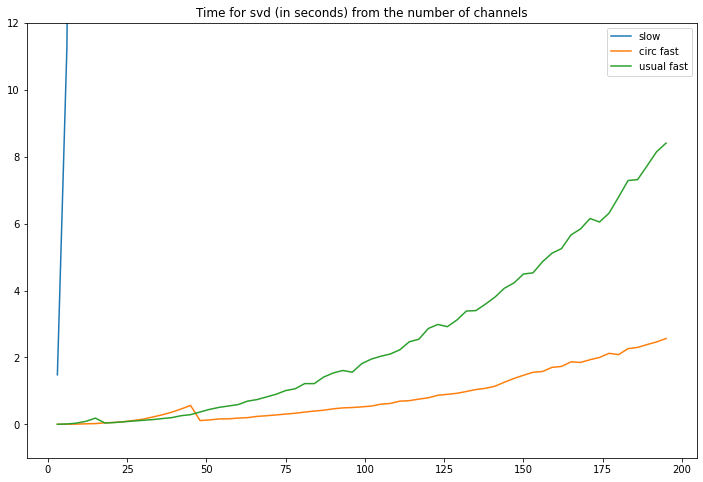

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))

plt.plot(list(range(3, 3 * len(res_slow) + 1, 3)), res_slow, label='slow')
plt.plot(list(range(3, 3 * len(res_cfast) + 1, 3)), res_cfast, label='circ fast')
plt.plot(list(range(3, 3 * len(res_ufast) + 1, 3)), res_ufast, label='usual fast')
plt.legend()
plt.title('Time for svd (in seconds) from the number of channels')
plt.ylim(-1, 12)
plt.show()